In [ ]:
%%bash
git add my_toy_nn2.ipynb

In [ ]:
%%bash
git commit -a -m "checkpoint"

In [5]:
1+1

2

In [25]:
import torch
torch.cuda.is_available()

True

torch.cuda.empty_cache()

torch.cuda.init()

os.environ["CUDA_VISIBLE_DEVICES"] 

In [ ]:
%matplotlib inline

https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe

#  準備

* 正解がゼロとイチであるような100個のデータを作る
* ゼロの方よりイチのほうがすべての座標の平均が1.5大きい

import os
#os.environ["CUDA_VISIBLE_DEVICES"]  ='0'


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [3]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X3 = torch.randn(1000,50) + 3
X = torch.cat([X1, X2 , X3], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y3 = torch.zeros(1000 , 1)
Y = torch.cat([Y1, Y2, Y3], dim=0)

In [ ]:
print(X.size())
print(Y.size())

In [ ]:
fig = plt.figure()

In [ ]:
ax1 = fig.add_subplot(111)

In [ ]:
ax1.scatter(X1[:,0] , X1[:,2] , color = "yellow")

In [ ]:
ax1.scatter(X2[:,0] , X2[:,2], color = "red")

In [ ]:
ax1.scatter(X3[:,0] , X3[:,2] , color = "yellow")

In [ ]:
fig

In [ ]:
X1.shape

In [ ]:
Y1.shape

# ネットワークの定義

## main model


$    \text{PReLU}(x) = \max(0,x) + a * \min(0,x)$


In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=50)
        self.relu1 = nn.ReLU()
        #self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        y = self.fc1(input_)
        y = self.relu1(y)        
        y = self.fc2(y)
        y = self.prelu(y)
        y = self.out(y)
        y = self.out_act(y)
        return y
    
    

## 線形変換 (値が0,1間に入らないのでcriteriaを評価できずエラーになる)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

##  線形変換＋sigmoid

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        y = self.out_act(a1)
        return y
    

## もともとのモデル

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    

In [ ]:
model = Net()

In [ ]:
print(model)

# optimizer

## 学習測度はここで指定する

learning rate次第で学習の成否が大きく異なってくる

In [ ]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Binary cross entropy

ふたつの確率分布$p,q$があったときクロスエントロピーは

$$
H(p,q) =-{\rm E}_p[\log(q)]
$$

で定義される

説明変数のsample 
$$
x_0,x_1,\cdots , x_{N-1}
$$
に対して、正解が１であり、NNが確率$z$で１であると出力したとき、
正解の確率分布は


$$
 p(x) =
 \begin{cases}
        1 & x = 1\\
        0 & x = 0
 \end{cases}
$$
NNの導いた確率分布は
$$
 q(x) =
 \begin{cases}
        z & x = 1\\
        1-z & x = 0
 \end{cases}
$$
なのでクロスエントロピーは
$$
H(p,q) = -\log(z)
$$
であるが、
$$
H(q,p) = -z \log(1) - (1-z) \log(0)
$$
は計算できない

In [ ]:
criterion = nn.BCELoss()

# my training

training modeに

In [ ]:
model.train()

In [ ]:
def yield_batch(X , Y , batch_size):
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        yield x_batch  ,y_batch
    

In [ ]:
batch_size = 50

In [ ]:
def my_one_epoch(model , opt, criterion, X , Y , batch_size):
    batch_iterator = yield_batch(X , Y  , batch_size)
    for x_batch , y_batch in batch_iterator:

        ## loop decomposed

        ### zero grad
        #毎回gradをクリアしないといけない

        opt.zero_grad()

        ### Forward

        y_hat = model(x_batch)

        ### Compute diff

        loss = criterion(y_hat, y_batch)
        #print("loss : {}".format(loss))

        ### Compute gradients

        loss.backward()

        ### update weights

        opt.step()        

        ### loss 

        run_loss = float(loss.data.numpy())

    print(run_loss)

In [ ]:
n_epochs = 20
for i in range(n_epochs):
    my_one_epoch(model , opt, criterion, X , Y , batch_size)

#  答え合わせ

In [ ]:
y_model = model(X)

In [ ]:
fig = plt.figure()

In [ ]:
ax1 = fig.add_subplot(111)

In [ ]:
Y.numpy()[:,0]

In [ ]:
ax1.scatter(Y.numpy()[:,0] , y_model.detach().numpy()[:,0] , color = "red")

In [ ]:
fig

In [ ]:
tmp = y_model.detach().numpy()

# decomposed training

In [ ]:
batch_iterator = yield_batch(X , Y  , batch_size)

In [ ]:
x_batch , y_batch = next(batch_iterator)

## loop decomposed

### zero grad
毎回gradをクリアしないといけない

In [ ]:
opt.zero_grad()

### Forward

In [ ]:
y_hat = model(x_batch)

### Compute diff

In [ ]:
loss = criterion(y_hat, y_batch)
print("loss : {}".format(loss))

### Compute gradients

In [ ]:
loss.backward()

### update weights

In [ ]:
opt.step()        

### loss 

In [ ]:
run_loss = float(loss.data.numpy())

print(run_loss)

# original

def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)


        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [ ]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
plt.plot(e_losses)

In [ ]:
?Variable

In [ ]:
batch_size = 50

In [ ]:
losses = []
for beg_i in range(0, X.size(0), batch_size):
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = Variable(x_batch)
    y_batch = Variable(y_batch)

    opt.zero_grad()
    # (1) Forward
    y_hat = net(x_batch)
    # (2) Compute diff
    loss = criterion(y_hat, y_batch)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())

In [ ]:
loss.backward?

In [ ]:
plt.plot(losses)

In [ ]:
print(losses)

In [ ]:
train_epoch(net, opt, criterion)

# option pricing imitation


In [7]:
import QuantLib as ql 

In [8]:
class cl_call:
    def price(self , spot_price, strike_price, maturity , is_american = True):
        if maturity <= 0:
            exercise_value = np.max([0 , spot_price - strike_price])
            return (exercise_value)
        dummy_strike = strike_price / spot_price
        

        option_type = ql.Option.Call
        payoff = ql.PlainVanillaPayoff(option_type, dummy_strike)
        
        maturity_date = self.calculation_date + int(365.0 * maturity)
        settlement = self.calculation_date
        if is_american:
            run_exercise = ql.AmericanExercise(settlement, maturity_date)
        else:
            run_exercise = ql.EuropeanExercise(maturity_date)
                
        
        american_option = ql.VanillaOption(payoff, run_exercise)
        if is_american:
            american_option.setPricingEngine(self.binomial_engine)
        else:

            american_option.setPricingEngine(ql.AnalyticEuropeanEngine(self.bsm_process))
                
        ql.Settings.instance().evaluationDate = self.calculation_date

        return (american_option.NPV() * spot_price)
        

    def __init__(self , volatility , dividend_rate , risk_free_rate  ,steps):
        day_count = ql.Actual365Fixed()
        #calendar = ql.UnitedStates()
        calendar = ql.Japan()
        self.calculation_date = ql.Date(8, 5, 2015)
        dummy_spot = 1
        
        self.spot_handle = ql.QuoteHandle(ql.SimpleQuote(1.0))

        ql.Settings.instance().evaluationDate = self.calculation_date


        self.flat_ts = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, risk_free_rate, day_count)
        )

        self.dividend_yield = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, dividend_rate, day_count)
        )

        #### volatility

        self.flat_vol_ts = ql.BlackVolTermStructureHandle(
            ql.BlackConstantVol(self.calculation_date, calendar, volatility, day_count)
        )

        #### BS framework

        self.bsm_process = ql.BlackScholesMertonProcess(self.spot_handle, 
                                                   self.dividend_yield, 
                                                   self.flat_ts, 
                                                   self.flat_vol_ts)


        self.binomial_engine = ql.BinomialVanillaEngine(self.bsm_process, "crr", steps)
        



In [9]:
spot_price = 127.62
volatility = 0.20 # the historical vols or implied vols
dividend_rate =  0.063
risk_free_rate = 0.001
maturity = 1
dt = 0.1

strike_price = 130

#steps = 200
pricer_steps = 100

#dt = maturity / steps

## sandbox

In [ ]:
am_call = cl_call(volatility ,  dividend_rate ,  risk_free_rate , pricer_steps)

In [ ]:
am_call.price(spot_price, strike_price, maturity)

In [ ]:
am_call.price(130 , 100, 0.1 , True)

In [ ]:
am_call.price(130 , 100 , 0.1,  False)

In [ ]:
am_call.price(130 , 100 , 0.1 , True)

## creating training data

In [10]:
N = 1000


In [11]:
share_prices  = torch.rand(N, 1) * 300

In [12]:
volatilities = torch.rand(N , 1) * 0.6 + 0.01

In [13]:
dividend_rates= torch.rand(N , 1) * 0.1

In [14]:
share_prices[0,0].item()

35.603355407714844

In [15]:
option_prices = [cl_call(volatilities[i , 0].item() ,  
                         dividend_rates[i , 0].item() ,  
                         risk_free_rate , 
                         pricer_steps).price(share_prices[i,0].item(), 
                                              strike_price, 
                                              maturity) for i in range(N)]

In [16]:
X = torch.cat([share_prices , volatilities , dividend_rates] , dim = 1)

In [17]:
X.size()

torch.Size([1000, 3])

In [18]:
y = torch.tensor(option_prices)

In [19]:
y = y.view(-1, 1)

In [20]:
y.size()

torch.Size([1000, 1])

## define net

https://pytorch.org/docs/stable/nn.html

### 線形モデルはきつい

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

### reluをつかいつつ中間層をそれなりに大きくするとわりと性能が良い

In [21]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3, 50)
        self.a1 = nn.ReLU()
        self.fc2 = nn.Linear(50 , 1)
    def forward(self, input_, **kwargs):
        y = self.fc1(input_)
        y = self.a1(y)
        y = self.fc2(y)
        
        return y
    

### softplusモデルも同様に良い

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3, 30 , True)
        self.a1 = nn.Softplus()
        self.fc2 = nn.Linear(30 , 1)
    def forward(self, input_):
        y = self.fc1(input_)
        y = self.a1(y)
        y = self.fc2(y)
        
        return y
    

In [22]:
model = Net()

In [23]:
print(model)

Net(
  (fc1): Linear(in_features=3, out_features=50, bias=True)
  (a1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


## optimizer

[An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)

In [24]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

## define loss function
https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

[official doc](https://pytorch.org/docs/stable/optim.html)

In [23]:
criterion = nn.MSELoss()

## training

In [24]:
model.train()

Net(
  (fc1): Linear(in_features=3, out_features=50, bias=True)
  (a1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [25]:
def train_epoch(model, opt, criterion, X, Y , batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [26]:
e_losses = []
num_epochs = 3000
for e in range(num_epochs):
    e_losses += train_epoch(model, opt, criterion , X , y)

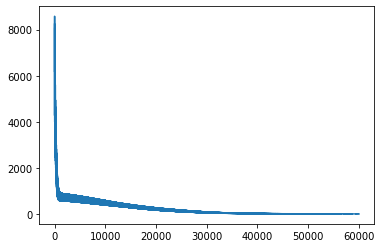

In [27]:
plt.plot(e_losses)

In [ ]:
y_model = model(X)

## plot with bokeh

In [ ]:
import bokeh.plotting as bp
from bokeh import palettes
bp.output_notebook()


In [ ]:
p = bp.figure()

In [ ]:
p.scatter(share_prices.numpy()[:,0] , y.numpy()[:,0])

In [ ]:
p.scatter(share_prices.numpy()[:,0] , y_model.detach().numpy()[:,0] , fill_color = "red")

In [ ]:
bp.show(p)

In [ ]:
1+1

In [ ]:
p = bp.figure()
p.scatter(y.numpy()[:,0] , y_model.detach().numpy()[:,0])
bp.show(p)

In [ ]:
p = bp.figure()
previous_y = run_y
run_y = y_model.detach().numpy()[:,0] - y.numpy()[:,0]

p.scatter(y.numpy()[:,0] , previous_y , color = 'yellow')
p.scatter(y.numpy()[:,0] , run_y)
bp.show(p)

In [ ]:
p = bp.figure()
#previous_y = run_y
#run_y = y_model.detach().numpy()[:,0] - y.numpy()[:,0]

p.scatter(run_y , previous_y )
#p.scatter(y.numpy()[:,0] , run_y)
bp.show(p)

## check results with matplotlib

In [ ]:
fig = plt.figure()

In [ ]:
ax1 = fig.add_subplot(111)

In [ ]:
ax1.scatter(y.numpy()[:,0] , y_model.detach().numpy()[:,0] , color = "red")

In [ ]:
fig

# skorch-based cross validation (forwardの引数をinputとtargetにするのがポイント）

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3, 50)
        self.a1 = nn.ReLU()
        self.fc2 = nn.Linear(50 , 1)
    def forward(self, input, target = None):
        y = self.fc1(input)
        y = self.a1(y)
        y = self.fc2(y)
        
        return y
    
model = Net()

In [33]:
from skorch import NeuralNetRegressor

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
device

'cpu'

## setting without L1 regularization

In [ ]:
wrapped_model = NeuralNetRegressor(
  model,            # ここで、先程定義したNetクラスを引数として与える
  max_epochs=10,
  optimizer=optim.Adam,
  lr=0.001,
  device=device,
  batch_size=128,
  # デフォルトだと入力データの2割が検証に使われる。入力データすべてを学習に使うためには、以下の通りにする
  # train_split=None,
  criterion= nn.MSELoss    # CNNの最後のactivationがlog_softmaxなので、lossはNLLoss。
)

In [ ]:
wrapped_model = NeuralNetRegressor(
  model)

In [ ]:
wrapped_model.set_params(# ここで、先程定義したNetクラスを引数として与える
  max_epochs=10,
  optimizer=optim.Adam,
  lr=0.001,
  device=device,
  batch_size=128,
  # デフォルトだと入力データの2割が検証に使われる。入力データすべてを学習に使うためには、以下の通りにする
  # train_split=None,
  criterion= nn.MSELoss    # CNNの最後のactivationがlog_softmaxなので、lossはNLLoss。
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

In [ ]:
start = time.time()
scores = cross_val_score(wrapped_model, X.numpy(), y.numpy(), cv=5) 
print("elapsed : {}".format(time.time() -start))


## setting withL1 regularization

https://skorch.readthedocs.io/en/latest/user/neuralnet.html

In [ ]:
class RegularizedNet(NeuralNetRegressor):
    def __init__(self, l1_penalty = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        #self.lambda1 = lambda1
        self.l1_penalty = 0.0
        self.l1_penalty = l1_penalty
    def set_l1_penalty(self , l1_penalty):
        self.l1_penalty = l1_penalty
        


    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss = super().get_loss(y_pred, y_true, X=X, training=training)
        regularization_loss = 0
        for param in self.module.parameters():
            regularization_loss += torch.sum(torch.abs(param))
        #loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        loss = loss + regularization_loss * self.l1_penalty
        return loss

### 二段階定義

In [ ]:
wrapped_model = RegularizedNet(module =   model)

In [ ]:
wrapped_model.set_params(# ここで、先程定義したNetクラスを引数として与える
  max_epochs=10,
  optimizer=optim.Adam,
  lr=0.001,
  device=device,
  batch_size=128,
  # デフォルトだと入力データの2割が検証に使われる。入力データすべてを学習に使うためには、以下の通りにする
  # train_split=None,
  criterion= nn.MSELoss   , # CNNの最後のactivationがlog_softmaxなので、lossはNLLoss。
    verbose = 0
)

### 一段階initialization (走らせ方は同じ)

In [ ]:
wrapped_model = RegularizedNet(
  module = model,            # ここで、先程定義したNetクラスを引数として与える
  max_epochs=10,
  optimizer=optim.Adam,
  lr=0.001,
  device=device,
  batch_size=128,
  # デフォルトだと入力データの2割が検証に使われる。入力データすべてを学習に使うためには、以下の通りにする
  # train_split=None,
  criterion= nn.MSELoss  ,  # CNNの最後のactivationがlog_softmaxなので、lossはNLLoss。
    verbose = 0
)

## analysis with sklearn

https://scikit-learn.org/stable/modules/cross_validation.html

### split data

In [ ]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X.numpy() , y.numpy(), test_size=0.4, random_state=0)

In [ ]:
from sklearn import preprocessing

In [ ]:
X_scaler = preprocessing.StandardScaler().fit(X_train)

In [ ]:
X_train_scaled = X_scaler.transform(X_train)

In [ ]:
X_train_tmp = scaler.inverse_transform(X_train_scaled)

In [ ]:
X_train_scaled

In [ ]:
X_train

In [ ]:
X_train_tmp

In [ ]:
X_train_tmp == X_train

In [ ]:
dir(scaler)

### fit

In [ ]:
wrapped_model.set_l1_penalty(10)
wrapped_model.fit(X_train , y_train)

In [ ]:
for p in wrapped_model.module.named_parameters():
    print(p)

In [ ]:
wrapped_model.get_params()

### cross_val_score

In [ ]:
from sklearn.model_selection import cross_val_score
wrapped_model.set_l1_penalty(0.1)
scores = cross_val_score(wrapped_model, X_train, y_train, cv=5) 

In [ ]:
scores

In [ ]:
import numpy as np

In [ ]:
np.mean(scores)

In [ ]:
score_means

#### check various penalties manually (not recommended)

In [ ]:
penalties = [0,0.0001 , 0.001 , 0.01 , 0.1 , 1, 10, 100 , 1000]
score_means = list()
for run_penalty in penalties:
    wrapped_model.set_l1_penalty(run_penalty)
    scores = cross_val_score(wrapped_model, X_train, y_train, cv=5) 
    score_mean = np.mean(scores)
    score_means += [score_mean]
    
    

In [ ]:
score_means

### tuning hyperparameters with sklearn
https://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'l1_penalty':[0,0.001,0.1]}

In [ ]:
clf = GridSearchCV(wrapped_model , param_grid , cv = 5)

In [ ]:
clf.fit(X_train , y_train)

In [ ]:
clf.cv_results_

# skorchに頼らないcross validation(まだうまく動作していない)

scikit-learn 準拠の予測モデルのつくりかた
https://nykergoto.hatenablog.jp/entry/2017/05/14/003503

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
class wrap_model(BaseEstimator, ClassifierMixin):
    """
    分類器のサンプル
    """
    
    def __init__(self, model , opt , criterion , batch_size):
        """
        分類器のコンストラクタ
        全部の引数に初期値を与えること !!
        
        :param int int_val:
        :param float sigma:
        :param str hogevalue:
        """
        self.model = model
        self.opt = opt
        self.criterion = criterion
        self.batch_size = batch_size
        
         
    def fit(self, X, y=None):
        """
        データへのフィッティングを行うメソッド。
        すべての加工, パラメータの確認はここで定義する。
        Note: `assert`よりも`try/exception`を用いるほうが本当は良い. けどめんどうなのでassert使ってます
        
        :param numpy.ndarray X: 2-D array. 訓練特徴
        :param numpy.ndarray y: 1-D array. ターゲット変数
        :return: self
        :rtype: SampleClassifer
        """
        #assert(isinstance(self.int_val, int) or isinstance(self.int_val, np.int64)), "int_valは整数値でないと駄目です. "
        #self.treshold_ = (sum(X)/len(X)) + self.int_val
        #return self  # return selfするのが慣習
    
        train_epoch(self.model, self.opt, self.criterion, torch.Tensor(X), torch.Tensor(y) , batch_size= self.batch_size)
        return self 
    

        
    def predict(self, X, y=None):
        """
        予測を行う
        :param numpy.ndarray X: 特徴量. 2-D array
        :param numpy.ndarray y: ターゲット変数. 分類問題なので使わないけど`y=None`でおいておく
        :return: 1-D array
        :rtype: np.ndarray
        """
        #try:
        #    getattr(self, "treshold_")
        #except AttributeError:
        #    raise RuntimeError("モデルは訓練されていません")
        ty = self.model(torch.Tensor(X))
        y = ty.detach().numpy()
        return y
        #return ([self._meaning(x) for x in X])
    
    def score(self, X, y=None):
        """
        モデルの良さを数値化する
        なんでもいいけれど、大きい方が良くて、小さいほうがだめ。
        今回は平均以上の値がいくつあるかをスコアとして定義する。
        
        :return: 平均値の値よりも大きい数
        :rtype: int
        """
        return (sum(self.predict(X)))

In [ ]:
wrapped_model = wrap_model(model , opt , criterion , batch_size  = 50)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(wrapped_model, X.numpy(), y.numpy(), cv=5) 

In [ ]:
scores

In [ ]:
scores

In [ ]:
class SampleClassifer(BaseEstimator, ClassifierMixin):
    """
    分類器のサンプル
    """
    
    def __init__(self, int_val=0, sigma=.5, hogevalue=None):
        """
        分類器のコンストラクタ
        全部の引数に初期値を与えること !!
        
        :param int int_val:
        :param float sigma:
        :param str hogevalue:
        """
        self.int_val = int_val
        self.sigma = sigma
        self.hogevalue = hogevalue
        self.huga = hogevalue  # 引数とインスタンス変数の名前が違っている. 非推奨. 
         
    def fit(self, X, y=None):
        """
        データへのフィッティングを行うメソッド。
        すべての加工, パラメータの確認はここで定義する。
        Note: `assert`よりも`try/exception`を用いるほうが本当は良い. けどめんどうなのでassert使ってます
        
        :param numpy.ndarray X: 2-D array. 訓練特徴
        :param numpy.ndarray y: 1-D array. ターゲット変数
        :return: self
        :rtype: SampleClassifer
        """
        assert(isinstance(self.int_val, int) or isinstance(self.int_val, np.int64)), "int_valは整数値でないと駄目です. "
        self.treshold_ = (sum(X)/len(X)) + self.int_val
        return self  # return selfするのが慣習
    
    def _meaning(self, x):
        """
        平均値よりも大きければTrueを返す分類
        :rtype: bool
        """
        if x > self.treshold_:
            return True
        else:
            return False
        
    def predict(self, X, y=None):
        """
        予測を行う
        :param numpy.ndarray X: 特徴量. 2-D array
        :param numpy.ndarray y: ターゲット変数. 分類問題なので使わないけど`y=None`でおいておく
        :return: 1-D array
        :rtype: np.ndarray
        """
        try:
            getattr(self, "treshold_")
        except AttributeError:
            raise RuntimeError("モデルは訓練されていません")
            
        return ([self._meaning(x) for x in X])
    
    def score(self, X, y=None):
        """
        モデルの良さを数値化する
        なんでもいいけれど、大きい方が良くて、小さいほうがだめ。
        今回は平均以上の値がいくつあるかをスコアとして定義する。
        
        :return: 平均値の値よりも大きい数
        :rtype: int
        """
        return (sum(self.predict(X)))

## plot with plotnine

https://www.kaggle.com/princeashburton/an-intro-to-plotnine

In [ ]:
import pandas as pd

In [ ]:
from plotnine import *

# sandbox

In [35]:
?NeuralNetRegressor

Init signature:
NeuralNetRegressor(
    module,
    *args,
    criterion=<class 'torch.nn.modules.loss.MSELoss'>,
    **kwargs,
)
Docstring:     
NeuralNet for regression tasks

Use this specifically if you have a standard regression task,
with input data X and target y. y must be 2d.

In addition to the parameters listed below, there are parameters
with specific prefixes that are handled separately. To illustrate
this, here is an example:

>>> net = NeuralNet(
...    ...,
...    optimizer=torch.optimizer.SGD,
...    optimizer__momentum=0.95,
...)

This way, when ``optimizer`` is initialized, :class:`.NeuralNet`
will take care of setting the ``momentum`` parameter to 0.95.

(Note that the double underscore notation in
``optimizer__momentum`` means that the parameter ``momentum``
should be set on the object ``optimizer``. This is the same
semantic as used by sklearn.)

Furthermore, this allows to change those parameters later:

``net.set_params(optimizer__momentum=0.99)``

This can be u

In [41]:
?nn.Module

Init signature: nn.Module()
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
           x = F.relu(self.conv1(x))
           return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.
File:           ~/anaconda3/envs/base2/lib/python3.7/site-packages/torch/nn/modules/module.py
Type:           type
Subclasses:     Identity, Linear, Bilinear, _ConvNd, Threshold, ReLU, RReLU, Hardtanh, Sigmoid, Tanh, ...


In [42]:
dir(nn.Module)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_get_name',
 '_load_from_state_dict',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forward_pre_hook',
 'register_parameter